<h2 style="text-align:center;font-size:200%;;"> Data Exploration and Analysis [Pyspark] </h2>

In [1]:
# %%capture
# !pip install -r requirements.txt
# !pip install nbconvert

# 1. Initialize pyspark framework

In [2]:
%cd /app

/app


In [3]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats

matplotlib.rcParams["figure.dpi"] = 100
InteractiveShell.ast_node_interpurchase = "all" 
%matplotlib inline

sys.path.append('src')


In [4]:
# Import PySpark related modules
from utils.data_exploration import init_spark, spark_load_data

spark = init_spark( MAX_MEMORY='4G')

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/21 04:07:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# def spark_load_data(spark, filename_path):
#     df = pd.read_excel(filename_path)
#     spark_df = spark.createDataFrame(df)
#     print("Data frame type: " + str(type(spark_df)))
#     return spark_df
        

In [6]:
# filename_path = "data/purchase_data.xltx"
filename_path = "data/purchase_data_sample.xlsx"

# Load the main data set into pyspark data frame 
spark_df = spark_load_data(spark, filename_path)


24/10/21 04:07:43 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


There are total 100 rows
   Cust_ID             Name  Age                Date  Price  Quantity  \
0    17011  Zachary Roberts   29 2023-01-15 00:44:35    181         4   
1     3176   Cathy Martinez   67 2021-06-27 22:22:58    135         2   
2    17378    Brenda Harris   45 2022-02-11 07:08:28    322         3   
3    16890       Amy Bailey   59 2022-01-19 04:57:55    -86         1   
4     8010     Justin Parks   65 2022-07-26 21:57:45     38         3   

   Purch_Amt     Category  Returns  Gender  Churn  
0        724     Clothing      0.0  Female      0  
1        270     Clothing      NaN  Female      1  
2        966         Home      NaN    Male      0  
3        -86  Electronics      1.0  Female      0  
4        114         Home      0.0    Male      1  


In [146]:
# filename_path = "data/purchase_data_sample.xlsx"

# # save sample data 
# save_sample_data(df, filename_path, nrows=100)


# 2. Overview of Dataset

In [7]:
spark_df.describe().toPandas()
print(f"There are total {spark_df.count()} row, Lets show 5 rows:")
spark_df.limit(5).toPandas()

Data frame stats (string and numeric columns only):
There are total 100 row, Lets show 5 rows:


,Cust_ID,Name,Age,Date,Price,Quantity,Purch_Amt,Category,Returns,Gender,Churn
0,17011,Zachary Roberts,29,2023-01-15 00:44:35,181,4,724,Clothing,0.0,Female,0
1,3176,Cathy Martinez,67,2021-06-27 22:22:58,135,2,270,Clothing,NaN,Female,1
2,17378,Brenda Harris,45,2022-02-11 07:08:28,322,3,966,Home,NaN,Male,0
3,16890,Amy Bailey,59,2022-01-19 04:57:55,-86,1,-86,Electronics,1.0,Female,0
4,8010,Justin Parks,65,2022-07-26 21:57:45,38,3,114,Home,0.0,Male,1


### 2.1 Schema  & datatypes
   *The data columns format (bigint, timestamp, double, string) and columns made of signle values not arrays/list.*

In [149]:
print("Data Columns overview")
spark_df.printSchema()
pd.DataFrame(spark_df.dtypes, columns = ["Column Name","Data type"]).set_index(["Column Name"]).T

Data Columns overview
root
 |-- Cust_ID: long (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: long (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Price: long (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- Purch_Amt: long (nullable = true)
 |-- Category: string (nullable = true)
 |-- Returns: double (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Churn: long (nullable = true)



Column Name,Cust_ID,Name,Age,Date,Price,Quantity,Purch_Amt,Category,Returns,Gender,Churn
Data type,bigint,string,bigint,timestamp,bigint,bigint,bigint,string,double,string,bigint


### 2.2 columns categories

In [150]:
from utils.data_exploration import categorize_columns

# categorize the different columns
string_columns,numeric_columns,array_columns, timestamp_columns,unkown_columns =categorize_columns(spark_df)

 timestamp_columns [size= 1] = ['Date']
 string_columns [size= 3] = ['Name', 'Category', 'Gender']
 numeric_columns [size= 7] = ['Cust_ID', 'Age', 'Price', 'Quantity', 'Purch_Amt', 'Returns', 'Churn']
 array_columns [size= 0] = []
 unkown_columns [size= 0] = []


# 3. Data preparation

In [105]:
from utils.data_exploration import count_missing_invalid_values

# count the missing values
count_missing_invalid_values(spark_df)


 timestamp_columns [size= 1] = ['Date']
 string_columns [size= 3] = ['Name', 'Category', 'Gender']
 numeric_columns [size= 7] = ['Cust_ID', 'Age', 'Price', 'Quantity', 'Purch_Amt', 'Returns', 'Churn']
 array_columns [size= 0] = []
 unkown_columns [size= 0] = []


,Cust_ID,Name,Age,Date,Price,Quantity,Purch_Amt,Category,Returns,Gender,Churn
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0
percentage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0


###  3.1 replace missing  values

- replace the 18% missingvalues of `Returns` by zero

In [106]:
# #Replace 0 for null on only population column 
# spark_df=spark_df.na.fill(value=0,subset=["Returns"])

# count the missing values
count_missing_invalid_values(spark_df)

 timestamp_columns [size= 1] = ['Date']
 string_columns [size= 3] = ['Name', 'Category', 'Gender']
 numeric_columns [size= 7] = ['Cust_ID', 'Age', 'Price', 'Quantity', 'Purch_Amt', 'Returns', 'Churn']
 array_columns [size= 0] = []
 unkown_columns [size= 0] = []


,Cust_ID,Name,Age,Date,Price,Quantity,Purch_Amt,Category,Returns,Gender,Churn
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
percentage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###  3.2 remove the invalid value (negative price, quantity, others)
- remove the 18% negative quantities  

In [136]:
# remove the invalid value (negative price, quantity, others)
nb_invalid_values = spark_df.select("*")\
        .where((col("Price")<0) | \
               (col("Quantity")<0) | \
               (col("Purch_Amt")<0) | \
               (col("Returns")<0) | \
               (col("Churn")<0)  ).count() 
total_nb_samples = spark_df.count()

if nb_invalid_values>=0:
    print(f"- {nb_invalid_values}/{total_nb_samples} invalid (negative) values are removed from the database ")  
    spark_df = spark_df.select("*")\
                        .where((col("Price")>=0) & \
                               (col("Quantity")>=0) & \
                               (col("Purch_Amt")>=0) & \
                               (col("Returns")>=0) & \
                               (col("Churn")>=0)  )


- 22/100 unvalid (negative) values are removed from the database 


###  3.3 remove the invalid computation(s) of Purch_Amt=Price*Quantity
- remove the 0% invalid computation(s)

In [139]:
# remove the invalid computation(s) of Purch_Amt=Price*Quantity
nb_invalid_Purch_Amt_values = spark_df.select("*")\
        .where((col("Price")*col("Quantity")!=col("Purch_Amt")) ).count()
if nb_invalid_Purch_Amt_values>=0:
    print(f"- {nb_invalid_values}/{total_nb_samples} invalid computation(s) of Purch_Amt=Price*Quantity. The sample will be removed ")  
    spark_df = spark_df.select("*")\
                        .where((col("Price")*col("Quantity")==col("Purch_Amt")) )

0

# 5. Explolatory Data analysis

### 5.0 Pyspark lazy evaluation

Here we will begin to be familiar with some of Advanced Spark feature: **Lazy evaluation**.

<font color="red"><b>Lazy evaluation</b></font> enhances the power of Apache Spark by reducing the execution time of the RDD operations. It maintains the lineage graph to remember the operations on RDD. we can simply remember that all processing in Pyspark is abstraction, When we want to return the results, actually we tell Spark what is the eventual answer you"re interested and it figures out best way to get there. As a result, it optimizes the performance and achieves fault tolerance. 

In order to see the result, we have to call Spark.collect(). 

Normolly, we can show the results with the syntax: spark_df.take(k) or spark_df.limit(k) to get the results with k row. 

When K become large number, These 2 way above takes a long time to complete the process. Because this syntax above did not utilize the power of Pyspark processing (Lazy evaluation).
In order to quickly processing , We should use spark_df.collect()[:k] to return the k row as we want.

You can read more about Pyspark lazy evaluation in : https://data-flair.training/blogs/apache-spark-lazy-evaluation/

In [112]:
spark_df.limit(5).toPandas()

,Cust_ID,Name,Age,Date,Price,Quantity,Purch_Amt,Category,Returns,Gender,Churn
0,29132,Louis Nicholson,74,2020-03-05 09:54:07,194,1,194,Books,0.0,Male,1
1,42824,Mr. Patrick Esparza MD,45,2020-03-11 20:51:11,117,1,117,Electronics,1.0,Male,0
2,29482,Zachary Evans MD,26,2020-03-16 08:09:53,90,4,360,Electronics,0.0,Male,0
3,23456,Jeffrey Swanson,52,2020-03-25 01:50:49,-12,2,-24,Home,0.0,Female,1
4,20663,Monica Fox,52,2020-03-26 21:04:28,82,3,246,Clothing,0.0,Female,0


In [113]:
ranked_product_clients_df = spark_df.select(spark_df.Category, spark_df.Cust_ID) \
    .distinct() \
    .groupBy(spark_df.Category) \
    .count() \
    .orderBy("count", ascending=False)

# Top 5 purchase types
highest_product_clients_df = ranked_product_clients_df.limit(5).toPandas()
# Rename column name : "count" --> Clients count
highest_product_clients_df.rename(columns = {"count":"Clients count"}, inplace = True)
# Caculate the total users, we will this result to compute percentage later
total_categories_clients = ranked_product_clients_df.groupBy().sum().collect()[0][0]

In [114]:
ranked_product_clients_df.collect()[:5]

[Row(Category='Home', count=26),
 Row(Category='Electronics', count=26),
 Row(Category='Books', count=25),
 Row(Category='Clothing', count=23)]

### 5.1 Income

In [16]:
import pyspark.sql.functions as f
#calculate sum of sales by month
monthly_spark_df=spark_df.groupBy(f.year("Date").alias("year"), f.month("Date").alias("month"))\
                         .agg(f.sum("Purch_Amt").alias("sum_Purch_Amt"),
                              f.avg("Purch_Amt").alias("avg_Purch_Amt"),
                              f.avg("Price").alias("avg_Price"),
                              f.avg("Quantity").alias("avg_Quantity"),
                              f.sum("Quantity").alias("sum_Quantity"),
                              f.avg("Age").alias("avg_Age"),
                              f.sum("Returns").alias("sum_Returns"),
                              f.sum("Churn").alias("sum_Churn")
                             )
monthly_spark_df=monthly_spark_df.select(*[f.round(c, 2).alias(c) for c in monthly_spark_df.columns]) 
monthly_spark_df = monthly_spark_df.withColumn("DateByMonth", f.expr("make_date(year, month, 1)")).orderBy("DateByMonth")
monthly_spark_df.show()

+----+-----+-------------+-------------+---------+------------+------------+-------+-----------+---------+-----------+
|year|month|sum_Purch_Amt|avg_Purch_Amt|avg_Price|avg_Quantity|sum_Quantity|avg_Age|sum_Returns|sum_Churn|DateByMonth|
+----+-----+-------------+-------------+---------+------------+------------+-------+-----------+---------+-----------+
|2020|    3|         1149|        191.5|    99.83|        2.17|          13|  49.17|        NaN|        2| 2020-03-01|
|2020|    5|          612|        306.0|    135.0|         3.5|           7|   33.0|        NaN|        1| 2020-05-01|
|2020|    6|          526|       175.33|    87.67|         2.0|           6|  55.67|        NaN|        0| 2020-06-01|
|2020|    8|          870|        870.0|    174.0|         5.0|           5|   70.0|        0.0|        0| 2020-08-01|
|2020|   11|         1212|        303.0|   243.25|        1.25|           5|   36.0|        NaN|        1| 2020-11-01|
|2021|    1|          901|        450.5|    228.

In [12]:
monthly_spark_df.toPandas()

,year,month,sum_Purch_Amt,avg_Purch_Amt,avg_Price,avg_Quantity,sum_Quantity,avg_Age,sum_Returns,sum_Churn,DateByMonth
0,2020,3,1149,191.50,99.83,2.17,13,49.17,NaN,2,2020-03-01
1,2020,5,612,306.00,135.00,3.50,7,33.00,NaN,1,2020-05-01
2,2020,6,526,175.33,87.67,2.00,6,55.67,NaN,0,2020-06-01
3,2020,8,870,870.00,174.00,5.00,5,70.00,0.0,0,2020-08-01
4,2020,11,1212,303.00,243.25,1.25,5,36.00,NaN,1,2020-11-01
5,2021,1,901,450.50,228.50,3.00,6,40.50,NaN,1,2021-01-01
6,2021,3,1006,503.00,251.50,2.00,4,66.00,2.0,1,2021-03-01
7,2021,4,2802,560.40,194.20,2.60,13,48.80,1.0,1,2021-04-01
8,2021,5,1177,392.33,120.67,3.00,9,35.33,2.0,1,2021-05-01
9,2021,6,2977,992.33,265.33,3.33,10,50.67,NaN,2,2021-06-01


In [108]:
from utils.data_exploration import plot_columns, generate_explode


In [109]:
monthly_spark_df.columns

['year',
 'month',
 'sum_Purch_Amt',
 'avg_Purch_Amt',
 'avg_Price',
 'avg_Quantity',
 'sum_Quantity',
 'avg_Age',
 'sum_Returns',
 'sum_Churn',
 'DateByMonth']

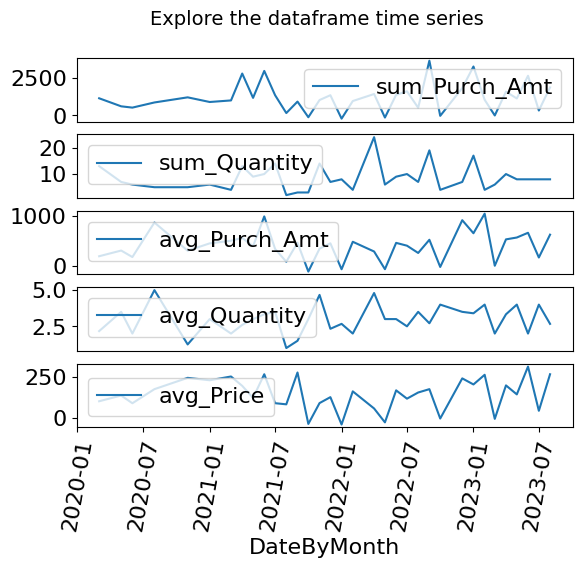

In [110]:
#  plot the purchase amount history
plot_columns(monthly_spark_df, 
             x_column="DateByMonth", 
             y_columns=["sum_Purch_Amt", "sum_Quantity", "avg_Purch_Amt", "avg_Quantity","avg_Price"], 
             subplot=True)

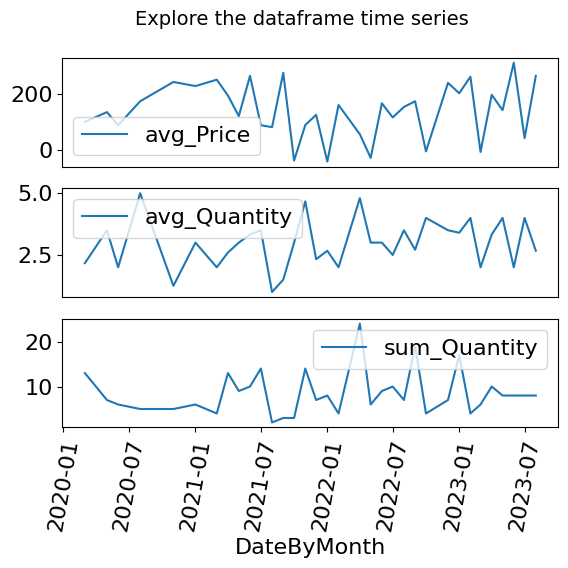

In [111]:
x_column="DateByMonth"
y_columns=["avg_Price","avg_Quantity", "sum_Quantity"]
#  plot the purchase history
plot_columns(monthly_spark_df, 
             x_column=x_column, 
             y_columns=y_columns,
             subplot=True)

### 5.2 Sales by clients

In [115]:
highest_product_clients_df_renamed = highest_product_clients_df
# Compute the percentage of top 5 purchase type / total users
highest_product_clients_df_renamed["percentage"] = highest_product_clients_df["Clients count"] \
    / total_categories_clients * 100

# We assign the rest of users belong to another specific group that we call "others"
others = {"Category": "others", 
          "Clients count": total_categories_clients - np.sum(highest_product_clients_df_renamed["Clients count"]),
          "percentage": 100 - np.sum(highest_product_clients_df_renamed["percentage"])
}

highest_product_clients_df_renamed = pd.concat([highest_product_clients_df_renamed, pd.DataFrame(others, index=[0])], ignore_index=True)
print("Top 5 categories that have the most users purchased:")
highest_product_clients_df_renamed

Top 5 categories that have the most users purchased:


,Category,Clients count,percentage
0,Home,26,26.0
1,Electronics,26,26.0
2,Books,25,25.0
3,Clothing,23,23.0
4,others,0,0.0


In [116]:
highest_product_clients_df_renamed["Clients count"]

0    26
1    26
2    25
3    23
4     0
Name: Clients count, dtype: int64

/tmp/ipykernel_5123/2420413989.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  xsticks_label = axs[0].set_xticklabels(highest_product_clients_df_renamed["Category"]


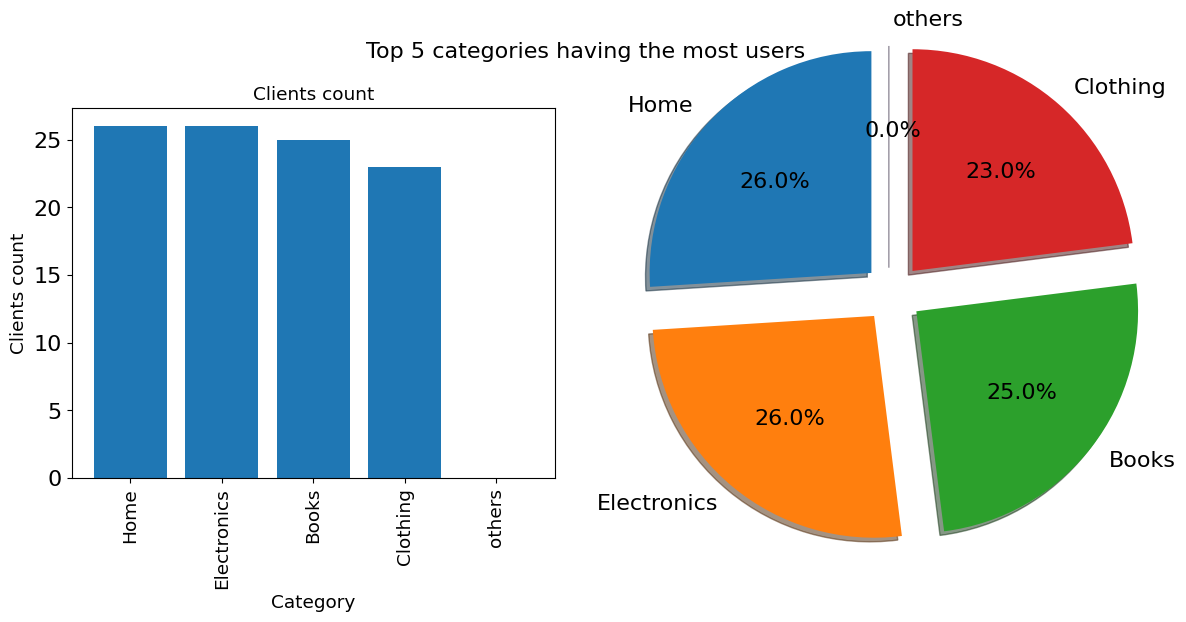

In [117]:
# fig = plt.figure(figsize=(19.20,10.80))
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

plot0 =   axs[0].bar(x=highest_product_clients_df_renamed["Category"]
                     , height=highest_product_clients_df_renamed["Clients count"])
title0 =  axs[0].set_title("Clients count", fontsize = "small")
xlabel0 = axs[0].set_xlabel("Category", fontsize = "small")
ylabel0 = axs[0].set_ylabel("Clients count", fontsize = "small")
xsticks_label = axs[0].set_xticklabels(highest_product_clients_df_renamed["Category"] 
                                       ,rotation = "vertical", fontsize="small")
nb_categories=len(np.unique(highest_product_clients_df_renamed["Category"]))
explode = generate_explode(nb_categories)
# title1 = axs[1].set_title("User ratio", fontsize = "small")
plot1 = axs[1].pie(
      x=highest_product_clients_df_renamed["percentage"]
    , labels=highest_product_clients_df_renamed["Category"]
    , autopct="%1.1f%%", shadow=True, startangle=90 , explode=explode
    , radius=1.5
)

text = fig.text(0.5, 1.02, 
                "Top 5 categories having the most users", 
                ha="center", 
                va="top", 
                transform=fig.transFigure)
# fig.savefig('output', format='svg', dpi=1200)
plt.show()

### 5.3 Sales by gender

The data shows that all categories have almost same number of client.

In [118]:
# Let quick overview purchases by gender
# we have something like this
purchases_by_gender = spark_df.groupBy("Category", "Gender").count().toPandas() 
purchases_by_gender[:5]

,Category,Gender,count
0,Clothing,Male,11
1,Electronics,Female,11
2,Books,Female,12
3,Home,Female,14
4,Clothing,Female,12


# 6. UNSTACK PYSPARK DATAFRAME

We want reshape the table above to flatten the gender column so that we can visualize on it. I draw a simple draft as follow 
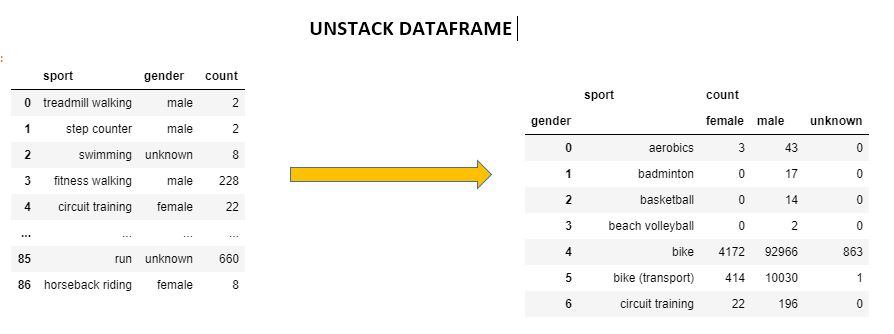

To reshape the table like this in Pyspark, we use 
```python
spark_df.unstack()
```

There are total: 4 purchases and here is the chart for purchases based on gender:


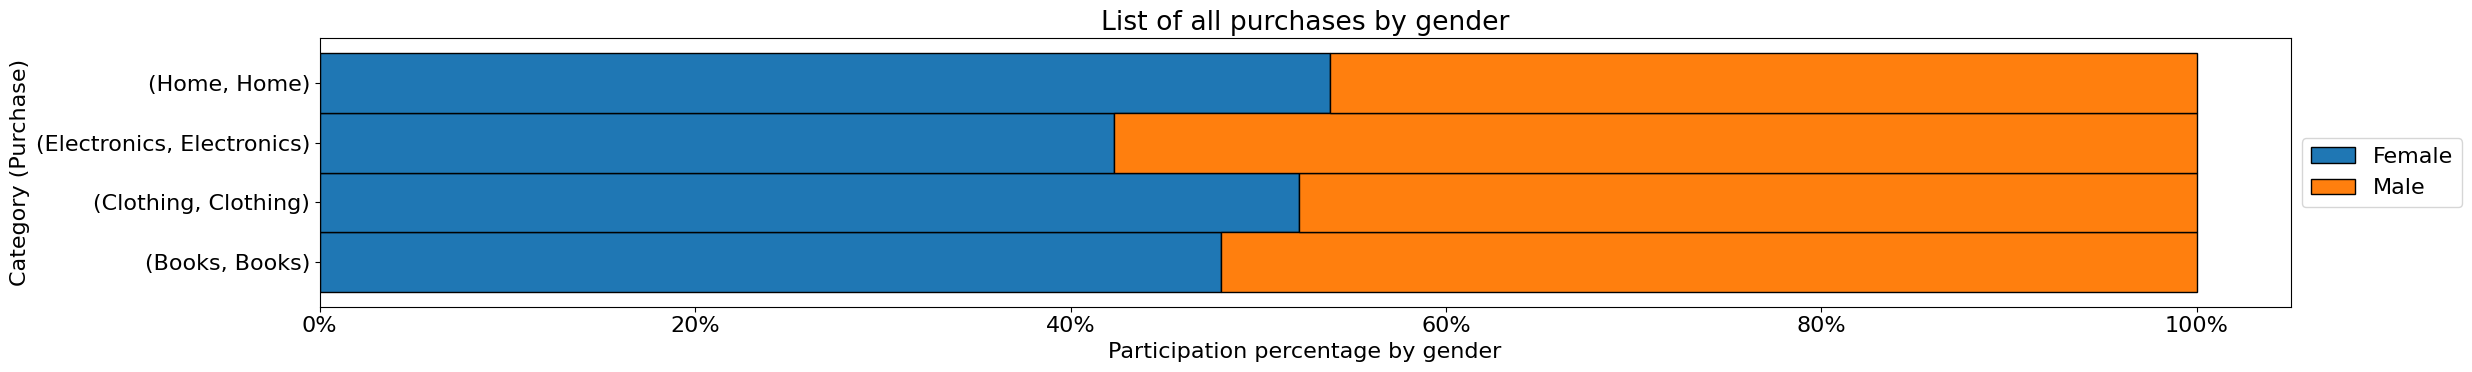

In [119]:
total_purchases = ranked_product_clients_df.count()
print(f"There are total: {total_purchases} purchases and here is the chart for purchases based on gender:")
# Add the infor of purchases based on gender
purchases_by_gender = spark_df.groupBy("Category", "Gender").count().toPandas()
nb_categories=len(np.unique(purchases_by_gender["Category"]))

# Visualize
fig = plt.figure(figsize=(25, nb_categories))
grid_size = (1,1);
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
plot = purchases_by_gender.groupby(["Category", "Gender"]).agg(np.mean).groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind="barh", stacked=True, width=1  ## APPLY UNSTACK TO RESHAPE DATA
                , edgecolor="black", ax=ax, title="List of all purchases by gender")
ylabel = plt.ylabel("Category (Purchase)");
xlabel = plt.xlabel("Participation percentage by gender");
legend = plt.legend(
    sorted(purchases_by_gender["Gender"].unique()), loc="center left", bbox_to_anchor=(1.0, 0.5)
)
param_update = plt.rcParams.update({"font.size": 16});
ax = plt.gca()
formatter = ax.xaxis.set_major_formatter(mtick.PercentFormatter());
a = fig.tight_layout()
plt.show()

It seems that there **no domminent** gender across all shoing categories

In [120]:
purchases_by_gender_df = purchases_by_gender.pivot_table(
    index="Category", columns="Gender", values="count", fill_value=0) \
    .reset_index().rename_axis(None, axis=1)

purchases_by_gender_df["total"] = purchases_by_gender_df["Male"] \
        + purchases_by_gender_df["Female"] 
purchases_by_gender_df["percentage"] = purchases_by_gender_df["total"] \
    / np.sum(purchases_by_gender_df["total"]) * 100
top_purchases_by_gender_df = purchases_by_gender_df.sort_values(
    by="percentage", ascending=False
).head(5)

others = {"Category" : "others"}
for column in ["Female", "Male", "total", "percentage"]:
    value = np.sum(purchases_by_gender_df[column]) - np.sum(top_purchases_by_gender_df[column])
    others.update({column: value})
# top_purchases_by_gender_df = top_purchases_by_gender_df.append(others, ignore_index=True)
top_purchases_by_gender_df = pd.concat([top_purchases_by_gender_df, pd.DataFrame(others, index=[0])], ignore_index=True)

top_purchases_by_gender_df = top_purchases_by_gender_df.sort_values(
    by="percentage", ascending=False
)
top_purchases_by_gender_df


,Category,Female,Male,total,percentage
0,Electronics,11,15,26,26.0
1,Home,14,12,26,26.0
2,Books,12,13,25,25.0
3,Clothing,12,11,23,23.0
4,others,0,0,0,0.0


/tmp/ipykernel_5123/788860331.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  xsticks_label = axs[0].set_xticklabels(top_purchases_by_gender_df["Category"]


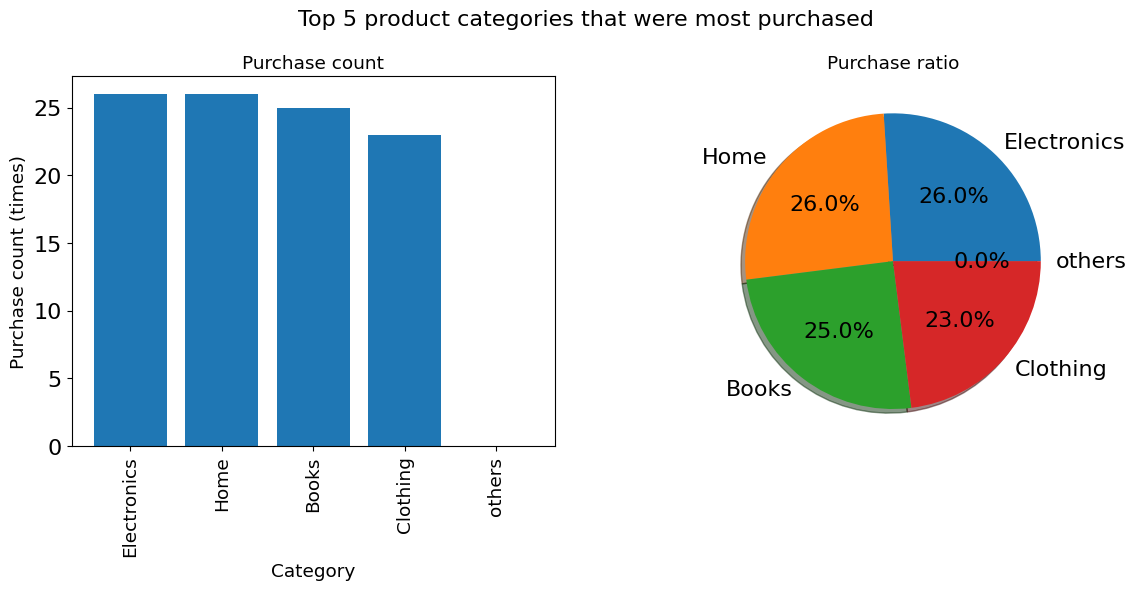

In [121]:

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

plot0 = axs[0].bar(x=top_purchases_by_gender_df["Category"]
                   , height=top_purchases_by_gender_df["total"])
title0 = axs[0].set_title("Purchase count", fontsize="small")
xlabel0 = axs[0].set_xlabel("Category", fontsize="small")
ylabel0 = axs[0].set_ylabel("Purchase count (times)", fontsize="small")
xsticks_label = axs[0].set_xticklabels(top_purchases_by_gender_df["Category"]
                                       , rotation="vertical", fontsize="small")
explode =  generate_explode(nb_categories)
title1 = axs[1].set_title("Purchase ratio", fontsize = "small")
plot1 = axs[1].pie(
    x=top_purchases_by_gender_df["percentage"]
    , labels=top_purchases_by_gender_df["Category"]
    , autopct="%1.1f%%", shadow=True, radius=1#, explode=explode
)

text = fig.text(0.5, 1.02, "Top 5 product categories that were most purchased"
                , ha="center", va="top", transform=fig.transFigure)

Similarly, it seems all product categories are purchased equally 

In [122]:
spark_df.columns

['Cust_ID',
 'Name',
 'Age',
 'Date',
 'Price',
 'Quantity',
 'Purch_Amt',
 'Category',
 'Returns',
 'Gender',
 'Churn']

In [123]:

product_spdf = spark_df \
    .select(spark_df.Cust_ID, spark_df.Gender, spark_df.Category) \
    .groupBy(spark_df.Cust_ID, spark_df.Gender) \
    .count().orderBy("count", ascending = False)  

# for nb_products in 
min_number_of_categories = 1
count_nb_purchased_prouct={}
user_more_categories_df = product_spdf \
                    .filter(product_spdf["count"] == min_number_of_categories) \
                    .orderBy("count", ascending = False) \
                    .toPandas()
nb__purchased_prouct=user_more_categories_df["count"].sum()
count_nb_purchased_prouct.update({f"{min_number_of_categories}":nb__purchased_prouct})
user_more_categories_df.rename(columns = {"count":"shopping categories count"}, inplace = True)
user_more_categories_df.describe().astype(int).T
user_more_categories_df

,Cust_ID,Gender,shopping categories count
0,29216,Female,1
1,22973,Male,1
2,34076,Male,1
3,2993,Female,1
4,45412,Female,1
...,...,...,...
95,12183,Female,1
96,32091,Male,1
97,32769,Female,1
98,43690,Female,1


In [124]:
product_spdf.show()

+-------+------+-----+
|Cust_ID|Gender|count|
+-------+------+-----+
|  29216|Female|    1|
|  22973|  Male|    1|
|  34076|  Male|    1|
|   2993|Female|    1|
|  45412|Female|    1|
|   3176|Female|    1|
|  29261|Female|    1|
|  26333|Female|    1|
|  38900|Female|    1|
|  34760|  Male|    1|
|  29482|  Male|    1|
|  48786|Female|    1|
|  34268|Female|    1|
|  16890|Female|    1|
|  17378|  Male|    1|
|  44541|  Male|    1|
|   2108|  Male|    1|
|  12147|Female|    1|
|  45725|Female|    1|
|  48521|Female|    1|
+-------+------+-----+
only showing top 20 rows



In [125]:
from pyspark.sql.window import Window
spark_df.withColumn("unique", 
                    (f.count("Cust_ID")\
                     .over(Window.partitionBy("Cust_ID")) == 1)\
                    .cast('integer'))\
.orderBy("unique").show()

+-------+--------------------+---+-------------------+-----+--------+---------+-----------+-------+------+-----+------+
|Cust_ID|                Name|Age|               Date|Price|Quantity|Purch_Amt|   Category|Returns|Gender|Churn|unique|
+-------+--------------------+---+-------------------+-----+--------+---------+-----------+-------+------+-----+------+
|    409|        Charles Lane| 25|2023-07-12 19:53:16|  -76|       4|     -304|      Books|    0.0|Female|    0|     1|
|   1852|        Heather Wood| 24|2021-05-30 04:21:17|  116|       4|      464|   Clothing|    1.0|  Male|    0|     1|
|   1912|        Jaime Mccann| 62|2021-03-01 18:43:29|  139|       2|      278|      Books|    1.0|  Male|    1|     1|
|   2108|      Jessica Thomas| 29|2020-11-11 02:09:37|  136|       1|      136|       Home|    1.0|  Male|    0|     1|
|   2390|      Angela Daniels| 37|2021-09-14 19:28:41|  376|       2|      752|   Clothing|    1.0|  Male|    1|     1|
|   2993|           Don James| 47|2021-0

In [126]:
product_spdf.show()

+-------+------+-----+
|Cust_ID|Gender|count|
+-------+------+-----+
|  29216|Female|    1|
|  22973|  Male|    1|
|  34076|  Male|    1|
|   2993|Female|    1|
|  45412|Female|    1|
|   3176|Female|    1|
|  29261|Female|    1|
|  26333|Female|    1|
|  38900|Female|    1|
|  34760|  Male|    1|
|  29482|  Male|    1|
|  48786|Female|    1|
|  34268|Female|    1|
|  16890|Female|    1|
|  17378|  Male|    1|
|  44541|  Male|    1|
|   2108|  Male|    1|
|  12147|Female|    1|
|  45725|Female|    1|
|  48521|Female|    1|
+-------+------+-----+
only showing top 20 rows



*Based on the summary, there are 35200 clients purchased more than 1 product category. Among them in average a person bought about 2 product categories and there is some person playing up to 6 different product categories!* <br />
Now we look at the statistic by gender in box plot:

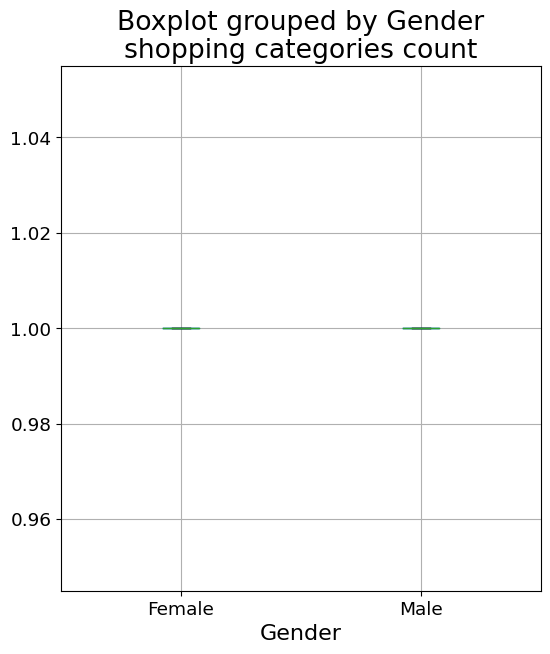

In [127]:
plot = user_more_categories_df.boxplot(column="shopping categories count", 
                                       by="Gender", fontsize="small", figsize=(6,7))

*The boxplot showed the similar distribution by gender wwithout clear outliers*

### Distribution of records count per purchase

*For a more detailed observation, we break down the record count per purchase into each individual sport. <br />Based on the distribution, the maximum records per purchase is 500, but not all purchases and sport types reach that number.*


Plot of purchased products category distribution by age:


/tmp/ipykernel_5123/3232844590.py:11: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  Cust_Category_dist = spark_df.select("Age", "Category").toPandas().hist(


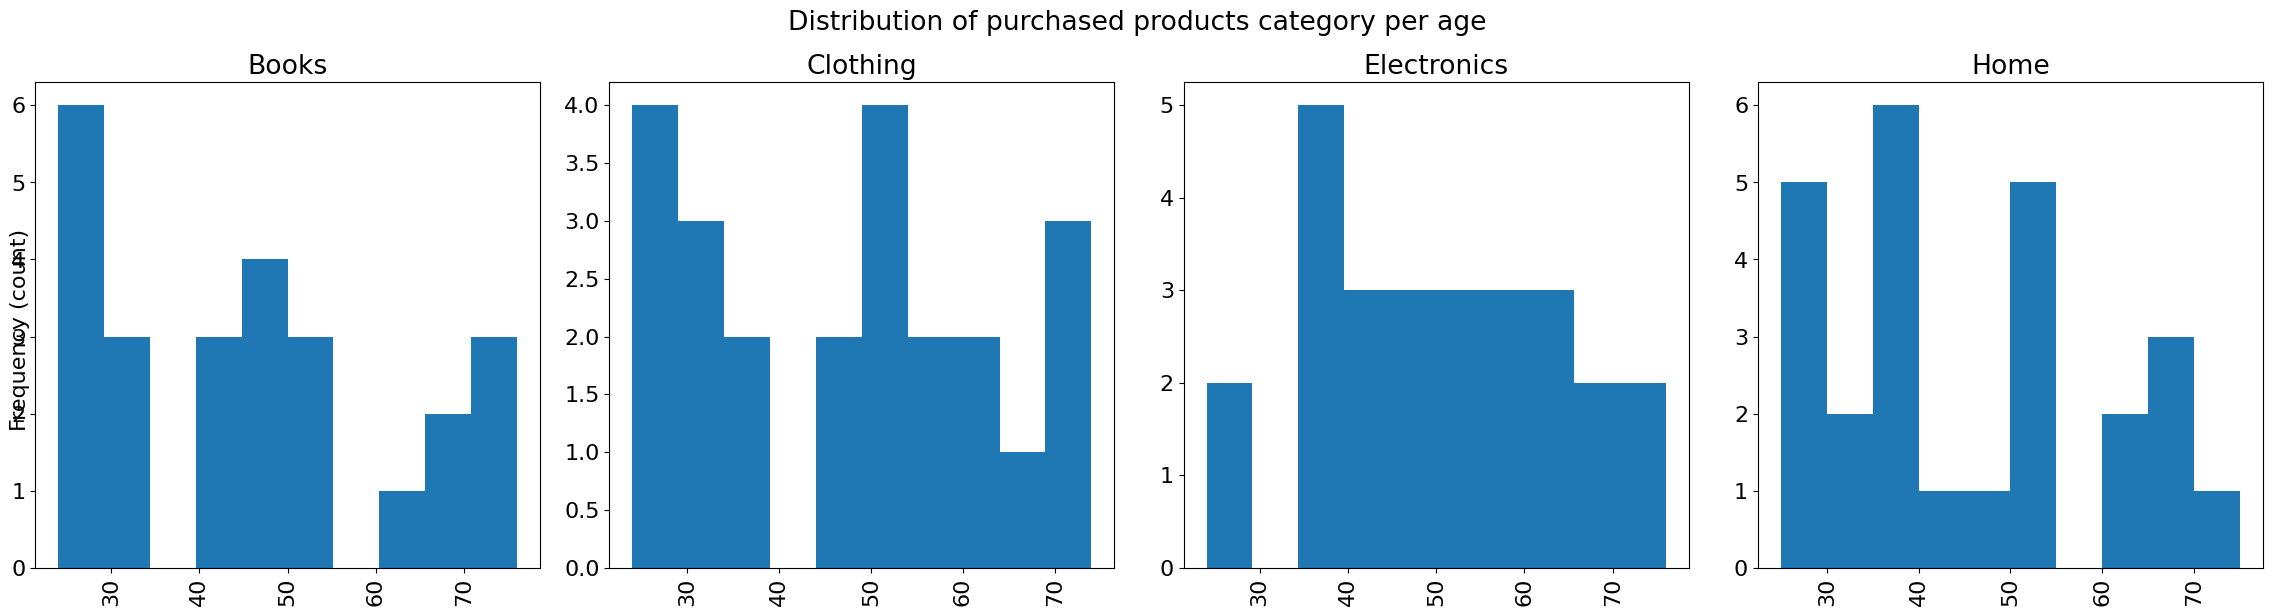

In [128]:
print("\nPlot of purchased products category distribution by age:")
plot_size_x, plot_size_y = 5, 5
list_categories = spark_df.select("Category").distinct().toPandas()["Category"]
nb_rows = len(list_categories)//4 + (1 if len(list_categories)%4>0 else 0 )
figsize_x, figsize_y = plot_size_x * 4 + 3, plot_size_y * nb_rows + 1
figsize=(figsize_x, figsize_y)
fig = plt.figure(figsize=figsize) #
grid_size = (nb_rows,4)
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
#fig, ax = plt.subplots()
Cust_Category_dist = spark_df.select("Age", "Category").toPandas().hist(
                                column="Age", by="Category", 
                                bins=10, sharex = False, grid=True, ax = ax,
                                layout = grid_size, figsize=figsize
                                )
a = fig.tight_layout()
title = fig.text(0.5, 1, "Distribution of purchased products category per age", ha="center" 
         , fontsize="large", transform=fig.transFigure);
ylabel = fig.text(0.01, 0.5, "Frequency (count)", va="center", rotation="vertical");

In [129]:
nb_purchases_threshold = 5
# Filter spark_df with at least 10 records (as we are assumming if any user_id with less then 10 record would not be meaningful)
qualified_df = spark_df \
    .select(spark_df.Category, spark_df.Cust_ID, spark_df.Gender) \
    .groupBy(spark_df.Category, spark_df.Cust_ID, spark_df.Gender) \
    .count()
qualified_df = qualified_df.filter(qualified_df["count"] >= nb_purchases_threshold) \
    .orderBy("count", ascending = False)

In [130]:
print(f"Number of users having more than {nb_purchases_threshold} purchases:")
qualified_pd_df = qualified_df.select("Cust_ID", "Gender").distinct() \
    .groupBy(qualified_df.Gender).count().toPandas()
qualified_pd_df.rename(columns={"count": "Clients count"}, inplace=True)
qualified_pd_df
qualified_clients_count = np.sum(qualified_pd_df["Clients count"])
total_clients_count = spark_df.select("Cust_ID").distinct().count()
qualified_percentage = round((qualified_clients_count / total_clients_count),2) * 100
print(f"\nSo there is {qualified_clients_count} / {total_clients_count} of users qualifying the {nb_purchases_threshold} historical records criteria, which is {qualified_percentage:.2f}%" \
     )

Number of users having more than 5 purchases:

So there is 0 / 100 of users qualifying the 5 historical records criteria, which is 0.00%


In [131]:
spark_df0=spark_df

# 7.High level metrics

In [135]:
spark_df=spark_df0

# Stats

In [1]:
#  Helper function to calculate statistic(s) of the column name from a tuple x of (sport, records list of the column)
#, the stats to calculate is also given as an input
def calculate_stats(x,column_name, stat_list):
    sport, records_list = x
    stat_dict = {"Category": sport}
    if "min" in stat_list:
        min_stat = min(records_list)
        stat_dict.update({"min " + column_name : min_stat})
    if "max" in stat_list:
        max_stat = max(records_list)
        stat_dict.update({"max " + column_name: max_stat})
    if "mean" in stat_list:
        average_stat = stats.mean(records_list)
        stat_dict.update({"mean " + column_name: average_stat})
    if "stdev" in stat_list:
        std_stat = stats.stdev(records_list)
        stat_dict.update({"stdev " + column_name: std_stat})
    if "50th percentile" in stat_list:
        median_stat = stats.median(records_list)
        stat_dict.update({"50th percentile " + column_name: median_stat})
    if "25th percentile" in stat_list:
        percentile_25th_stat = np.percentile(records_list, 25)
        stat_dict.update({"25th percentile " + column_name: percentile_25th_stat})
    if "75th percentile" in stat_list:
        percentile_75th_stat = np.percentile(records_list, 75)
        stat_dict.update({"75th percentile " + column_name: percentile_75th_stat})
    if "95th percentile" in stat_list:
        percentile_95th_stat = np.percentile(records_list, 95)
        stat_dict.update({"95th percentile " + column_name: percentile_95th_stat})
    return stat_dict

def to_list(a):
    return a

def extend(a, b):
    a.extend(b)
    return a

def retrieve_array_column_stat_df(spark_df, column_name, stat_list):
    # Convert sport & "column_name" to RDD to easily calculate the statistics of intervals by categories
    product_record_rdd = spark_df.select("Category", column_name).rdd \
    .map(tuple).combineByKey(to_list, extend, extend).persist()

    # Calculate statistics of the input column by calling calculate_stats function defined above
    record_statistic_df = pd.DataFrame(product_record_rdd.map(
        lambda x: calculate_stats(x, column_name,stat_list)).collect()
                                      )
    # Set proper dataframe column orders
    columns_order = ["Category"] + [stat + " " + column_name for stat in stat_list]
    # Re order columns
    return record_statistic_df[columns_order]

stat_list = ["min", "25th percentile", "mean", "50th percentile",
                     "75th percentile", "95th percentile", "max", "stdev"]
interval_statistic_df = retrieve_array_column_stat_df(spark_df, column_name="interval", stat_list=stat_list)
print("\nLet\"s look at statistic for interval, in seconds (by sport):" )
interval_statistic_df

NameError: name 'spark_df' is not defined

Now we plot those numbers in bar (for quantiles statistics) and line charts (for min/max/mean/stdev) for a more visualized feel.  
*Note: Due to the fact that the maximum interval and stdev have a much higher order of magnitude compared to the remaining columns, we need to put those 2 columns in a separate y axis on the right.*

In [ ]:
print("\nSummarize statistics of interval sport:")
bar_columns = ["25th percentile interval", "50th percentile interval"
               , "75th percentile interval", "95th percentile interval"]
line_columns1 = ["min interval", "mean interval"] 
line_columns2 = ["max interval", "stdev interval"] 
interval_statistic_df = interval_statistic_df.sort_values(
    by="95th percentile interval", ascending=False
)
figsize=(13, 59)
fig, axs = plt.subplots(nrows=7, figsize=figsize)

d = axs[0].set_title("Interval statistics by sport", fontsize=18)
for i in range (7):
    interval_statistic_sub_df = interval_statistic_df.iloc[i*7:i*7+7,]
    #interval_statistic_sub_df
    plot1 = interval_statistic_sub_df[["Category"] + bar_columns] \
        .groupby(["Category"]).agg(np.mean).plot(
        kind="bar", stacked=True, grid=False, alpha=0.5, edgecolor="black", ax=axs[i], 
    )
    plot2 = interval_statistic_sub_df[["Category"] + line_columns1].plot(x="Category", ax=axs[i], marker="o")
    ax2 = axs[i].twinx()
    plot3 = interval_statistic_sub_df[["Category"] + line_columns2].plot( x="Category", ax=ax2, marker="o", color=["m", "g"])
    a = axs[i].legend(loc="center left", fontsize=16, bbox_to_anchor=(1.2, 0.5), frameon=False)
    a = ax2.legend(  labels=["max interval (right)", "stdev interval (right)"]
                   , loc="center left", fontsize=16, bbox_to_anchor=(1.2, 0.11), frameon=False)
    b = axs[i].set_xticklabels(interval_statistic_sub_df["Category"],rotation = "horizontal", fontsize="small")
    c = axs[i].set_xlabel("Category (Purchase)", fontsize="small");
    d = axs[i].set_ylabel("Quantiles Statistics + min/mean\n(second)", fontsize=16);
    e = ax2.set_ylabel("Max/stdev Statistics\n(second)", fontsize=16)
    for tick in axs[i].yaxis.get_major_ticks():
        a = tick.label.set_fontsize(16) 
    ax2.tick_params(axis="y", labelsize=16)
    b = plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)

plt.subplots_adjust(hspace=0.2)
plt.show();


Looking at the quantiles statistic, up to 95% of the interval data set does not have the interval larger than 400 seconds, while there are just a few outliers that made the maximum intervals reach up to 86400 seconds (a full days).

In [ ]:
# Retrive the table of gender, sport and purchase_start_time for plotting
start_time_df = spark_df.select("Gender", "Category","purchase_start_time").toPandas()

In [ ]:
purchases = start_time_df["Category"].unique()
plot_size_x, plot_size_y = 5, 5
figsize_x, figsize_y = (plot_size_x + 0.5) * 4 +3, (plot_size_y + 1) * 13 + 1


nrows, ncols = 13, 4
a = fig.subplots_adjust(hspace = 1, wspace = 1)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize_x, figsize_y))
print("\nPlotting distribution of purchase start time per sport type, break down by gender:")
a = plt.setp(axs, xticks=[0, 4, 8, 12, 16, 20])
for index, sport in enumerate(purchases):
    row_index, col_index = divmod(index, ncols)
    male_start_time_list = start_time_df[(start_time_df.sport == sport) & 
                                            (start_time_df.Gender == "Male")]["purchase_start_time"]
    female_start_time_list = start_time_df[(start_time_df.sport == sport) & 
                                            (start_time_df.Gender == "Female")]["purchase_start_time"]
    unknown_start_time_list = start_time_df[(start_time_df.sport == sport) & 
                                            (start_time_df.Gender == "unknown")]["purchase_start_time"]
    if len(male_start_time_list) > 0:
        male_dist = axs[row_index, col_index].hist(male_start_time_list,
                                      bins = 12, alpha=0.5, label="Male", range=(0, 23))
    if len(female_start_time_list) > 0:    
        female_dist = axs[row_index, col_index].hist(female_start_time_list,
                                      bins = 12, alpha=0.5, label="Female", range=(0, 23))
    if len(unknown_start_time_list) > 0:
        unknown_dist = axs[row_index, col_index].hist(unknown_start_time_list,
                                      bins = 12, alpha=0.5, label = "unknown", range=(0, 23))
    b= axs[row_index, col_index].set_title("Activitiy: " + sport, fontsize="small")
    a = axs[row_index, col_index].legend(loc="upper left", fontsize="small")
    a = plt.setp(axs[row_index, col_index].get_xticklabels(), fontsize="small")

for i in range(1,4):
    x = axs[12, i].set_visible(False)
a = fig.tight_layout()
z = fig.text(0.5, 1, "Distribution of purchase started time (hour) by sport"
             , ha="center", va="top", transform=fig.transFigure)
y = fig.text(0.5, 0.01, "Purchase started hour in a day (hour)"
             , ha="center", va="bottom", transform=fig.transFigure)
z = fig.text(0.02, 0.5, "Frequency (count)", va="center", rotation="vertical");

In [ ]:
stat_list = ["min", "25th percentile", "mean", "95th percentile", "max", "stdev"]
heart_rate_statistic_df = retrieve_array_column_stat_df(spark_df, column_name="heart_rate", stat_list=stat_list)

*Due to the huge amount of users and purchase numbers, we just picked randomly up to a x number of users per gender (ex, 5), and up to y purchases per purchase type (ex, 10).<br />*

In [ ]:
# Support function helping to sample data
def sampling_data(max_clients_per_gender, max_purchases_per_sport):
    """
        max_clients_per_gender: maximum number of user to be selected randomly per gender
        max_purchases_per_sport: maximum number of purchases to be selected per sport 
        (the categories existing in selected users)
    """
    # Get unique list of Cust_ID and gender, for sampling purpose
    users_genders = spark_df.select("Cust_ID", "Gender").distinct().toPandas()
    # Use "sample" function to pick up to 3 Cust_ID per gender from the unique Cust_ID list
    random_x_clients_per_gender = users_genders.groupby("Gender")["Cust_ID"].apply(
                lambda s: s.sample(min(len(s), max_clients_per_gender))
    )

    # Apply filter on the main pyspark dataframe for sampling
    samples_by_gender = spark_df.where(spark_df.Cust_ID.isin(list(random_x_clients_per_gender)))

    # Next, generate the unique purchase ids and sport types list from the sampled data set 
    purchase_categories = samples_by_gender.select("id", "Category").distinct().toPandas()
    # Use "sample" function to pick up to 10 purchase ids for each kind of sport 
    random_y_purchases_per_sport = purchase_categories.groupby("Category")["id"].apply(
        lambda s: s.sample(min(len(s), max_purchases_per_sport))
    )

    # Apply filter to the sampled dataset to continue reduce the number of purchases per purchase type
    samples_by_gender_and_sport = samples_by_gender.where(spark_df.id.isin(list(random_y_purchases_per_sport)))
    return samples_by_gender_and_sport

In [ ]:
# Use 2 variable to determine the sampling criteria: 
# maximum users per gender and maximum purchases per sport
max_clients_per_gender, max_purchases_per_sport = 20, 15

# Collect the sampled data set to Pandas to be used with plot features
pd_df = sampling_data(max_clients_per_gender, max_purchases_per_sport).toPandas()
print("\nSampled data overview (only string and numeric columns):")
pd_df.describe()

we will normalize the time for all purchases by calulating the duration (in seconds) of each timestamp record from the first record of a purchase (the first datetime element of the list in that purchase). <br />
Then we plot the heart rate on this normalized time, grouping by sport.

In [ ]:
# Lambda function to flatten a list of lists into a big single list
flattern = lambda l: set([item for sublist in l for item in sublist])

normalized_datetime_list = []
for index,data_row in pd_df.iterrows():
    min_date_time = min(data_row["date_time"])
    normalized_datetime_list.append(
        [(date_time - min_date_time).seconds for date_time in data_row["date_time"]]
    )

pd_df["normalized_date_time"] = normalized_datetime_list

print("New normalized datetime (first 7 rows):")
pd_df.head(7)[["Cust_ID", "Category", "date_time","normalized_date_time"]]

print("\nPlot raw heart rate (sampled) by normalized time:")

product_list = pd_df["Category"].unique()
# Define the length of the figure dynamically depends on the length of the sport list
fig, axs = plt.subplots(len(product_list), figsize=(15, 6*len(product_list)))
subplot_adj = fig.subplots_adjust(hspace = 0.6)
plot_setp = plt.setp(axs, yticks=range(0,250,20))

for product_index, sport in enumerate(product_list):
    purchase = pd_df[pd_df.sport == sport]
    max_time = max(flattern(purchase.normalized_date_time))
    for purchase_index, data_row in purchase.iterrows():
        label = "user: " + str(data_row["Cust_ID"]) + " - gender: " + data_row["Gender"]
        plot_i = axs[product_index].plot(
            data_row["normalized_date_time"], data_row["heart_rate"], label=label
        )
    title_i = axs[product_index].set_title("Activitiy: " + sport, fontsize="small")
    xlabel_i = axs[product_index].set_xlabel("Time (sec)", fontsize="small")
    xsticklabels_i = axs[product_index].set_xticklabels(
        range(0, max_time, 500),rotation = "vertical", fontsize=9
    )
    ysticklabels_i = axs[product_index].set_yticklabels(range(0,250,20),fontsize="small")
    legend_i = axs[product_index].legend(
        loc="center left", bbox_to_anchor=(1.0, 0.5), prop={"size": 9}
    )

x_label = fig.text(0.04, 0.5, "Heart rate (bpm)", va="center", rotation="vertical")
chart_title = fig.text(0.5, 1.3, "Raw heart rate (sample) by normalized time", 
            ha="center", va="center", fontsize="small", transform=axs[0].transAxes)


In [ ]:
pd_df_small = sampling_data(max_clients_per_gender=2, max_purchases_per_sport=2).toPandas()
print("Sampled data (2 user, 2 purchases per sport):")
pd_df_small[["Cust_ID", "Gender","Category","id", "purchase_start_time"
             ,"PerWorkoutRecordCount", "duration", "longitude", "latitude", "altitude"]].describe()

In [ ]:
def get_fixed_mins_maxs(mins, maxs):
    deltas = (maxs - mins) / 12.
    mins = mins + deltas / 4.
    maxs = maxs - deltas / 4.

    return [mins, maxs]

purchase_count = pd_df_small.shape[0]
ncols = 3
nrows = math.ceil(purchase_count/ncols)
#purchase_count
fig = plt.figure(figsize=(8 * (ncols + 0.5), 8*nrows))

a = fig.subplots_adjust(hspace = 0.2, wspace=0.5)
#c = plt.setp(axs, yticks=range(0,250,20))

print("Plot purchase path in 3D graphs per each purchase:")
for row_index, row in pd_df_small.iterrows():
    if row_index==2:
        text = ax.text2D(
            0.01, 1, "Purchase path (longitude/latitude/altitude)"
            , fontsize=18, transform=ax.transAxes
        )
    min_long = min(row["longitude"]) - stats.stdev(row["longitude"])
    max_long = max(row["longitude"]) + stats.stdev(row["longitude"])
    minmax_long = get_fixed_mins_maxs(min_long, max_long)
    #minmax_long
    min_lat = min(row["latitude"]) - stats.stdev(row["latitude"])
    max_lat = max(row["latitude"]) + stats.stdev(row["latitude"])
    minmax_lat = get_fixed_mins_maxs(min_lat, max_lat)
    #minmax_lat
    min_alt = min(row["altitude"]) - stats.stdev(row["altitude"])
    max_alt = max(row["altitude"]) + stats.stdev(row["altitude"])
    minmax_alt = get_fixed_mins_maxs(min_alt, max_alt)
    #minmax_alt
    ax = fig.add_subplot(nrows, ncols, row_index + 1, projection="3d")
    title = "Activitiy: " + row["Category"] + " - Gender: " + row["Gender"] \
        + "\nRecords: " + str(int(row["PerWorkoutRecordCount"])) \
        + " - Duration: " + str(int(row["duration"])) + " minutes"
    title = ax.set_title(title, fontsize=16)
    scatter = ax.scatter(row["longitude"], row["latitude"], row["altitude"], c="r", marker="o")
    plot = ax.plot3D(
        row["longitude"], row["latitude"], row["altitude"], c="gray", label="Purchase path"
    )
    
    x_label = ax.set_xlabel("Longitude (Degree)", fontsize=16)
    y_label = ax.set_ylabel("Latitude (Degree)", fontsize=16)
    z_label = ax.set_zlabel("Altitude (m)", fontsize=16, rotation = 0)
    for t in ax.xaxis.get_major_ticks():
        font_size = t.label.set_fontsize(16)
    for t in ax.yaxis.get_major_ticks():
        font_size = t.label.set_fontsize(16)
    for t in ax.zaxis.get_major_ticks():
        font_size = t.label.set_fontsize(16)
    legend = ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
    ax.zaxis.set_rotate_label(False)
    #b = plt.setp(ax.get_xticklabels(), rotation=41)
    #b = plt.setp(ax.get_yticklabels(), rotation=-30)
    plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter("%.3f"))
    plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter("%.3f"))
    ax.pbaspect = [4, 2, 0.5]
    xlims = ax.set_xlim(minmax_long)
    ylims = ax.set_ylim(minmax_lat)
    # Some categories will not have altitude change so check it before set z limit
    if minmax_alt[0] != minmax_alt[1]: zlims = ax.set_zlim(minmax_alt)
    # Do this trick to enable tight_layout for 3D plot:
    for spine in ax.spines.values():
        b = spine.set_visible(False)
plt.rcParams["legend.fontsize"] = 16
a = plt.tight_layout()
plt.show()

Thank you for reading my work, wish you strong and stay safe

# 10. SYNTAX 
<!-- # **10. SYNTAX** <a class="anchor" id="7"></a>
[Go back to table of contents](#0.1) -->

In [ ]:
column="Returns"
spark_df.where(col(column).isin([None,np.nan])).collect()
# spark_df.select(column).distinct().collect()

#### SQL queries

In [ ]:
arima_df = sqldf(f"SELECT * \
                 FROM df \
                 WHERE Retained >0   \
                  AND  AdmitTerm IN {convert_list_quesry_format(AdmitTerm_list)} \
                  AND  School IN {convert_list_quesry_format(schools_list)} \
                  AND  Program IN {convert_list_quesry_format(programs_list)} \
                  AND  NationalStatus IN {convert_list_quesry_format(nationalStatus_list)} \
                 ORDER BY AdmitTerm \
                 LIMIT 10;")